
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# ハイパーパラメータの最適化とは何ですか?

 :label: `sec_what_is_hpo`

前の章で見てきたように、ディープ ニューラル ネットワークには、トレーニング中に学習される多数のパラメーターまたは重みが付属しています。これらに加えて、すべてのニューラル ネットワークには、ユーザーが構成する必要がある追加の*ハイパーパラメーター*があります。たとえば、確率的勾配降下法がトレーニング損失の局所最適値に確実に収束するようにするには (:numref: `chap_optimization`を参照)、学習率とバッチ サイズを調整する必要があります。トレーニング データセットの過学習を避けるために、重み減衰 (:numref: `sec_weight_decay`参照) やドロップアウト (:numref: `sec_dropout`を参照) などの正則化パラメータを設定する必要がある場合があります。層の数と層ごとのユニットまたはフィルターの数 (つまり、重みの有効数) を設定することによって、モデルの容量と誘導バイアスを定義できます。

残念ながら、トレーニング損失を最小限に抑えてこれらのハイパーパラメータを単純に調整することはできません。これは、トレーニング データの過剰適合につながるためです。たとえば、ドロップアウトや重み減衰などの正則化パラメーターをゼロに設定すると、トレーニングの損失がわずかに生じますが、汎化のパフォーマンスに悪影響を及ぼす可能性があります。 

![](http://d2l.ai/_images/ml_workflow.svg) :label: `ml_workflow`

別の形式の自動化がなければ、試行錯誤しながらハイパーパラメータを手動で設定する必要があり、これは機械学習ワークフローにおいて時間のかかる困難な部分となります。たとえば、CIFAR-10 で ResNet ( :numref: `sec_resnet`参照) をトレーニングする場合、Amazon Elastic Cloud Compute (EC2) `g4dn.xlarge`インスタンスで 2 時間以上必要になります。 10 個のハイパーパラメータ設定を順番に試すだけでも、すでにおよそ 1 日かかります。さらに悪いことに、ハイパーパラメータは通常、アーキテクチャやデータセット間で直接転送できないため (cite: `feurer-arxiv22,wistuba-ml18,bardenet-icml13a`新しいタスクごとに再最適化する必要があります。また、ほとんどのハイパーパラメータには経験則がなく、適切な値を見つけるには専門知識が必要です。

*ハイパーパラメータ最適化 (HPO)*アルゴリズムは、この問題をグローバル最適化問題としてフレーム化することで、原則に基づいた自動化された方法でこの問題に取り組むように設計されています:cite: `feurer-automlbook18a` 。デフォルトの目的はホールドアウト検証データセットのエラーですが、原則として他のビジネス指標でも構いません。トレーニング時間、推論時間、モデルの複雑さなどの二次的な目的と組み合わせたり、二次的な目的によって制約したりすることができます。

最近、ハイパーパラメータの最適化は*ニューラル アーキテクチャ検索 (NAS)* :cite: `elsken-arxiv18a,wistuba-arxiv19`に拡張され、その目標はまったく新しいニューラル ネットワーク アーキテクチャを見つけることです。従来の HPO と比較すると、NAS は計算コストがさらに高く、実際に実行可能であり続けるには追加の努力が必要です。 HPO と NAS はどちらも、ML パイプライン全体を自動化することを目的とした AutoML :cite: `hutter-book19a`のサブフィールドと考えることができます。

このセクションでは、HPO を紹介し、 :numref: `sec_softmax_concise`で紹介されたロジスティック回帰の例の最適なハイパーパラメーターを自動的に見つける方法を示します。

## 最適化問題

:label: `sec_definition_hpo`

簡単なおもちゃの問題から始めます。ファッション MNIST データセットの検証エラーを最小限に抑えるために、:numref: `sec_softmax_concise`からマルチクラス ロジスティック回帰モデル`SoftmaxRegression`の学習率を検索します。バッチ サイズやエポック数などの他のハイパーパラメータも調整する価値がありますが、ここでは簡単にするために学習率だけに焦点を当てます。


In [1]:
import numpy as np
import torch
from scipy import stats
from torch import nn
from d2l import torch as d2l


HPO を実行する前に、まず目的関数と構成空間という 2 つの要素を定義する必要があります。

### 目的関数

学習アルゴリズムのパフォーマンスは、ハイパーパラメータ空間 $\mathbf{x} \in \mathcal{X}$ から検証の損失。 $f(\mathbf{x})$ を評価するたびに、機械学習モデルをトレーニングして検証する必要があります。これは、大規模なデータセットでトレーニングされたディープ ニューラル ネットワークの場合、時間と計算量が膨大になる可能性があります。基準 $f(\mathbf{x})$ を考えると、目標は $\mathbf{x} *{\star} \in \mathrm{argmin}* {\mathbf{x} \in \mathcal{X}} f を見つけることです。 (\mathbf{x})$。

 $\mathbf{x}$ に関して $f$ の勾配を計算する簡単な方法はありません。訓練プロセス全体を通して勾配を伝播する必要があるからです。近似的な「超勾配」によって HPO を駆動する最近の研究 :cite: `maclaurin-icml15,franceschi-icml17a`ありますが、既存のアプローチはいずれもまだ最先端のものと競合できないため、ここでは説明しません。さらに、$f$ を評価する計算負荷により、HPO アルゴリズムはできるだけ少ないサンプルで大域最適に近づく必要があります。

ニューラル ネットワークのトレーニングは確率的であるため (たとえば、重みがランダムに初期化され、ミニバッチがランダムにサンプリングされる)、観測値にはノイズが多くなります。 $y \sim f(\mathbf{x}) + \epsilon$、ここで通常、 $\epsilon \sim N(0, \sigma)$ 観測ノイズはガウス分布であると仮定します。

これらすべての課題に直面して、私たちは通常、全体的な最適化を正確に達成するのではなく、パフォーマンスの良いハイパーパラメーター構成の少数のセットを迅速に特定しようとします。ただし、ほとんどのニューラル ネットワーク モデルでは大量の計算要求があるため、これでも数日から数週間の計算がかかる場合があります。 :numref: `sec_mf_hpo`では、検索を分散するか、目的関数の評価が安価な近似を使用することで、最適化プロセスを高速化する方法を検討します。

モデルの検証誤差を計算する方法から始めます。


In [2]:
class HPOTrainer(d2l.Trainer):  #@save
    def validation_error(self):
        self.model.eval()
        accuracy = 0
        val_batch_idx = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                x, y = self.prepare_batch(batch)
                y_hat = self.model(x)
                accuracy += self.model.accuracy(y_hat, y)
            val_batch_idx += 1
        return 1 -  accuracy / val_batch_idx


`learning_rate`で構成されるハイパーパラメータ構成`config`に関して検証誤差を最適化します。評価ごとに、モデルを`max_epochs`エポックに対してトレーニングし、その検証エラーを計算して返します。


In [3]:
def hpo_objective_softmax_classification(config, max_epochs=8):
    learning_rate = config["learning_rate"]
    trainer = d2l.HPOTrainer(max_epochs=max_epochs)
    data = d2l.FashionMNIST(batch_size=16)
    model = d2l.SoftmaxRegression(num_outputs=10, lr=learning_rate)
    trainer.fit(model=model, data=data)
    return trainer.validation_error().detach().numpy()


### 構成スペース

:label: `sec_intro_config_spaces`

目的関数 $f(\mathbf{x})$ に加えて、最適化するための実行可能集合 $\mathbf{x} \in \mathcal{X}$ も定義する必要があります。 これは、*構成空間*または*探索空間*と呼ばれます。ロジスティック回帰の例では、以下を使用します。


In [4]:
config_space = {"learning_rate": stats.loguniform(1e-4, 1)}


ここでは、対数空間で -4 と -1 の間の一様分布を表す SciPy の`loguniform`オブジェクトを使用します。このオブジェクトを使用すると、この分布から確率変数をサンプリングできます。

各ハイパーパラメータには、 `learning_rate`の`float`などのデータ型と、閉じた有界範囲 (つまり、下限と上限) があります。通常、サンプリング元の各ハイパーパラメータに事前分布 (均一または対数均一など) を割り当てます。 `learning_rate`などの一部の正のパラメーターは、最適値が数桁異なる可能性があるため、対数スケールで最もよく表されますが、運動量などのその他のパラメーターは線形スケールで表されます。

以下に、タイプと標準範囲を含む多層パーセプトロンの典型的なハイパーパラメータで構成される構成空間の簡単な例を示します。

 : 多層パーセプトロンの設定空間の例 :label: `tab_example_configspace`

 |名前 |タイプ |ハイパーパラメータ範囲 |対数スケール | | :----: | :----: |:------------------------------:|:---------- :| |学習率 |フロート | $[10^{-6},10^{-1}]$ |はい | |バッチサイズ |整数 | $[8,256]$ |はい | |勢い |フロート | $[0,0.99]$ |いいえ | |活性化関数 |カテゴリ別 | ${\text{tanh}、\text{relu}}$ | - | |ユニット数 |整数 | $[32, 1024]$ |はい | |レイヤー数 |整数 | $[1, 6]$ |いいえ |

一般に、構成空間 $\mathcal{X}$ の構造は複雑になる可能性があり、$\mathbb{R}^d$ とは大きく異なる場合があります。実際には、一部のハイパーパラメータは他のパラメータの値に依存する場合があります。たとえば、多層パーセプトロンの層の数と、各層のユニットの数を調整しようとすると仮定します。 $l\mathrm{-th}$ 層のユニット数は、ネットワークに少なくとも $l+1$ 層がある場合にのみ関係します。これらの高度な HPO の問題は、この章の範囲外です。興味のある読者は:cite: `hutter-lion11a,jenatton-icml17a,baptista-icml18a`を参照してください。

構成空間に含まれないものはアルゴリズムで検出できないため、構成空間はハイパーパラメータの最適化にとって重要な役割を果たします。一方、範囲が大きすぎると、パフォーマンスの良い構成を見つけるための計算量が現実的ではなくなる可能性があります。

## ランダム検索

:ラベル: `sec_rs`

*ランダム検索は、*最初に検討するハイパーパラメータ最適化アルゴリズムです。ランダム検索の主なアイデアは、事前定義された予算 (最大反復数など) がなくなるまで構成空間から独立してサンプリングし、観察された最良の構成を返すことです。すべての評価は独立して並列実行できます ( :numref: `sec_rs_async`参照) が、ここでは簡単にするためにシーケンシャル ループを使用します。


    validation_error = 0.17659997940063477


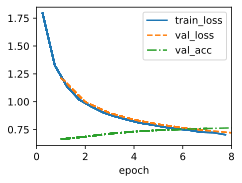

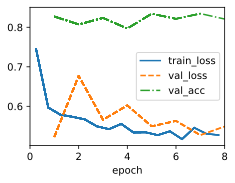

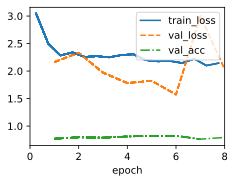

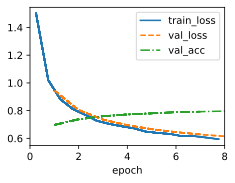

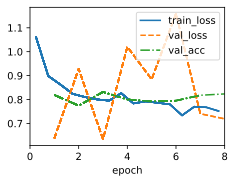

In [5]:
errors, values = [], []
num_iterations = 5

for i in range(num_iterations):
    learning_rate = config_space["learning_rate"].rvs()
    print(f"Trial {i}: learning_rate = {learning_rate}")
    y = hpo_objective_softmax_classification({"learning_rate": learning_rate})
    print(f"    validation_error = {y}")
    values.append(learning_rate)
    errors.append(y)


したがって、最良の学習率は、単純に検証エラーが最も低い学習率になります。


In [6]:
best_idx = np.argmin(errors)
print(f"optimal learning rate = {values[best_idx]}")

optimal learning rate = 0.24202220709278127



ランダム検索は、その単純さと汎用性により、最も頻繁に使用される HPO アルゴリズムの 1 つです。高度な実装は必要なく、ハイパーパラメータごとに何らかの確率分布を定義できる限り、あらゆる構成空間に適用できます。

残念ながら、ランダム検索にはいくつかの欠点もあります。まず、これまでに収集した前の観測値に基づいて標本分布を調整しません。したがって、パフォーマンスの悪い構成がサンプリングされる可能性は、パフォーマンスの高い構成よりも同じである可能性があります。第 2 に、初期パフォーマンスが悪く、以前に確認された構成を上回る可能性が低い場合でも、すべての構成に同じ量のリソースが費やされます。

次のセクションでは、検索をガイドするモデルを使用することでランダム検索の欠点を克服する、より効率的なハイパーパラメーター最適化アルゴリズムのサンプルを見ていきます。また、最適化プロセスをスピードアップするために、パフォーマンスの悪い構成の評価プロセスを自動的に停止するアルゴリズムについても説明します。

## まとめ

このセクションでは、ハイパーパラメータ最適化 (HPO) と、それを構成空間と目的関数を定義することによってグローバル最適化として表現する方法を紹介しました。また、最初の HPO アルゴリズムであるランダム検索を実装し、それを単純なソフトマックス分類問題に適用しました。

ランダム検索は非常に簡単ですが、固定されたハイパーパラメータのセットを評価するだけのグリッド検索よりも優れた代替手段です。ランダム検索は、次元の呪いをいくらか軽減します :cite: `bellman-science66` 。また、基準がハイパーパラメータの小さなサブセットに最も強く依存する場合は、グリッド検索よりもはるかに効率的です。

## 演習
1. この章では、素のトレーニング セットでトレーニングした後のモデルの検証誤差を最適化します。わかりやすくするために、コードでは`Trainer.val_dataloader`を使用します。これは、 `FashionMNIST.val`周りのローダーにマップされます。<ol><li>これは、トレーニングに元の FashionMNIST トレーニング セット (60000 例) を使用し、検証に元の*テスト セット*(10000 例) を使用することを意味することを (コードを見て) 納得してください。
1. なぜこの慣行が問題となるのでしょうか?ヒント: :numref: `sec_generalization_basics` 、特に*モデルの選択*について再読してください。
1. 代わりに何をすべきだったのでしょうか?
1. この目的で検証*エラーを*使用できないのはなぜですか?検証セットでどのようなメトリクスを使用しますか?
1.  1 エポックのトレーニング後の検証メトリックの計算グラフを (大まかに) スケッチします。初期の重みとハイパーパラメータ (学習率など) がこのグラフへの入力ノードであると想定できます。ヒント: :numref: `sec_backprop`の計算グラフについてもう一度読んでください。
1. このグラフの順方向パス中に保存する必要がある浮動小数点値の数の概算を与えます。ヒント: FashionMNIST には 60,000 件のケースがあります。必要なメモリは各層の後のアクティベーションによって占められていると想定し、 :numref: `sec_mlp-implementation`で層の幅を調べます。
1. 必要な膨大な量のコンピューティングとストレージのほかに、勾配ベースのハイパーパラメーターの最適化では他にどのような問題が発生するでしょうか?ヒント: :numref: `sec_numerical_stability`の勾配の消失と爆発についてもう一度読んでください。
1. *上級者*向け: 勾配ベースの HPO への洗練された (ただし、まだ多少非実用的な) アプローチについては、:cite: `maclaurin-icml15`を参照してください。
1. 基準がハイパーパラメータの小さなサブセットに最も強く依存する場合、ランダム検索は、かなりの数のハイパーパラメータに対する HPO のグリッド検索よりもはるかに効率的である可能性があると上で述べました。どうしてこれなの？ヒント: :cite: `bergstra2011algorithms`を読んでください。



[ディスカッション](https://discuss.d2l.ai/t/12090)
